In [88]:
import sys
import os
import json
import pickle
import shutil
import numpy as np
import pandas as pd
import imageio
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt   #not required

import sys
sys.path.append("..")
from txtProgressBar import printProgressBar2 as print2_

class SingleShot(object):
    """docstring for singleShot"""
    def __init__(self, id,
                 origRGB_dir, json_dir, rawBMPs_dirs, CSVfull_dir, 
                 CSVcrop_dir, CSVspec_dir, RGBwithPOV_dir, BMPwithPOV_dir):
        self.ExpShort  = 1
        self.ExpMedium = 4
        self.ExpLonger = 8

        
        self.leafLimit = (238, 306)
        self.grayLimit = (336, 364)
        self.index = None
        
        ######################### specicfic
        self.id       = id
        self.origRGB_dir      = origRGB_dir
        self.json_dir         = json_dir
        self.rawBMPs_dirs     = rawBMPs_dirs 
        #self.rawBMPs_dirs123  = rawBMPs_dirs 
        self.numBMPs          = len(self.rawBMPs_dirs) if self.rawBMPs_dirs else 0
        if len(self.rawBMPs_dirs) > 0:
            self.rawBMPs_dirs = ["{}_{}.bmp".format(os.path.join(os.path.dirname(self.rawBMPs_dirs[0]),self.id),integer) for integer in sorted([int(tmp.split('_')[-1].split('.')[0]) for tmp in self.rawBMPs_dirs])]
        self.CSVcrop_dir    = CSVcrop_dir
        self.CSVfull_dir    = CSVfull_dir
        self.CSVspec_dir    = CSVspec_dir
        self.RGBwithPOV_dir = RGBwithPOV_dir
        self.BMPwithPOV_dir = BMPwithPOV_dir
        
        self.jsonDic = None
        if self.json_dir != None:
            if os.path.isfile(self.json_dir):
                file = open(self.json_dir, 'r', encoding = 'utf-8')
                self.jsonDic = json.loads(file.read())
                file.close()
        
                
    def get_spectrumPxl(self, filename, startpixel, endpixel, outputfile = None): #pixel Vals
        img = np.rot90(imageio.imread(filename), k = 3)
        tmp = img[startpixel:endpixel, :]
        tmp = np.mean(tmp, 0)

        if outputfile != None:
            np.savetxt(outputfile, tmp, delimiter=',')
            print('saved as \"', outputfile, '\"')
        return tmp

    def readArrays_forClustering(self, startpixel, endpixel, numSection = 1, display = True):
        self.A = np.zeros((self.numBMPs, numSection, 480))
        for i in range(self.numBMPs):
            for j in range(numSection):
                self.A[i, j, :] = self.get_spectrumPxl(self.rawBMPs_dirs[i], startpixel, endpixel)
        return self.A

    def clustering(self, numClusters = 3):
        tmpWhites = np.zeros((self.numBMPs, 480))
        tmpWhites[:,:] = self.readArrays_forClustering(335, 365 ,1)[:,0,:]
        self.kmeans = KMeans(n_clusters=numClusters, random_state=0).fit(tmpWhites)
        self.kmeans.labels_
        clusternames = np.argsort(np.array((self.A[self.kmeans.labels_==0, 0,:][0,100],
                                            self.A[self.kmeans.labels_==1, 0,:][0,100],
                                            self.A[self.kmeans.labels_==2, 0,:][0,100])))
        #         self.spectrum_1 = np.zeros((self.A[self.kmeans.labels_==clusternames[0], 0,:].shape[0], 480))
        #         self.spectrum_4 = np.zeros((self.A[self.kmeans.labels_==clusternames[1], 0,:].shape[0], 480))
        #         self.spectrum_8 = np.zeros((self.A[self.kmeans.labels_==clusternames[2], 0,:].shape[0], 480))
        #         self.numBMP_1Exposure = self.A[self.kmeans.labels_==clusternames[0], 0,:].shape[0]
        #         self.numBMP_4Exposure = self.A[self.kmeans.labels_==clusternames[1], 0,:].shape[0]
        #         self.numBMP_8Exposure = self.A[self.kmeans.labels_==clusternames[2], 0,:].shape[0]
        
        self.numBMP_1Exposure = np.sum(self.kmeans.labels_==clusternames[0])
        self.numBMP_4Exposure = np.sum(self.kmeans.labels_==clusternames[1])
        self.numBMP_8Exposure = np.sum(self.kmeans.labels_==clusternames[2])
        self.fnameBMP_1Exposure = []
        self.fnameBMP_4Exposure = []
        self.fnameBMP_8Exposure = []
        
        #         for i in range(self.numBMP_1Exposure):
        #             self.spectrum_1[i,:] = self.A[self.kmeans.labels_==clusternames[0],0, :][i,:]
        #         for i in range(self.numBMP_4Exposure):
        #             self.spectrum_4[i,:] = self.A[self.kmeans.labels_==clusternames[1],0, :][i,:]
        #         for i in range(self.numBMP_8Exposure):
        #             self.spectrum_8[i,:] = self.A[self.kmeans.labels_==clusternames[2],0, :][i,:]

        for i in range(self.numBMPs):
            if (self.kmeans.labels_==clusternames[0])[i] == True:
                self.fnameBMP_1Exposure.append(self.rawBMPs_dirs[i])
            if (self.kmeans.labels_==clusternames[1])[i] == True:
                self.fnameBMP_4Exposure.append(self.rawBMPs_dirs[i])
            if (self.kmeans.labels_==clusternames[2])[i] == True:
                self.fnameBMP_8Exposure.append(self.rawBMPs_dirs[i])
            
    def showBMPs(self, exposure, size = (20,5)):
        if exposure == self.ExpShort:
            fig=plt.figure(figsize=size)
            for i in range(self.numBMP_1Exposure):
                img = np.rot90(imageio.imread(self.fnameBMP_1Exposure[i]), k = 3)
                fig.add_subplot(1, self.numBMP_1Exposure+1,  i+1)
                
                tmp = plt.imshow(img, vmax = 255, vmin =  0)
                plt.title(os.path.basename(self.fnameBMP_1Exposure[i]))
                tmp.axes.get_xaxis().set_visible(False)
                tmp.axes.get_yaxis().set_visible(False)
                

            plt.show()

        if exposure == self.ExpMedium:
            fig=plt.figure(figsize=size)
            for i in range(self.numBMP_4Exposure):
                img = np.rot90(imageio.imread(self.fnameBMP_4Exposure[i]), k = 3)
                fig.add_subplot(1, self.numBMP_4Exposure+1,  i+1)
                
                tmp = plt.imshow(img, vmax = 255, vmin =  0)
                plt.title(os.path.basename(self.fnameBMP_4Exposure[i]))
                tmp.axes.get_xaxis().set_visible(False)
                tmp.axes.get_yaxis().set_visible(False)

            plt.show()
            pass
        if exposure == self.ExpLonger:
            fig=plt.figure(figsize=size)
            for i in range(self.numBMP_8Exposure):
                img = np.rot90(imageio.imread(self.fnameBMP_8Exposure[i]), k = 3)
                fig.add_subplot(1, self.numBMP_8Exposure+1,  i+1)
                
                tmp = plt.imshow(img, vmax = 255, vmin =  0)
                plt.title(os.path.basename(self.fnameBMP_8Exposure[i]))
                tmp.axes.get_xaxis().set_visible(False)
                tmp.axes.get_yaxis().set_visible(False)

            plt.show()
            pass
    def readSection(self, startPixel, stopPixel ,BG=5.9, vMin = 17, vMax = 250):
        spectrum_1sect = np.zeros((self.numBMP_1Exposure, 480))
        spectrum_4sect = np.zeros((self.numBMP_4Exposure, 480))
        spectrum_8sect = np.zeros((self.numBMP_8Exposure, 480))
        
        for i in range(self.numBMP_1Exposure):
            spectrum_1sect[i,:] = self.get_spectrumPxl(self.fnameBMP_1Exposure[i], startPixel, stopPixel)
        for i in range(self.numBMP_4Exposure):
            spectrum_4sect[i,:] = self.get_spectrumPxl(self.fnameBMP_4Exposure[i], startPixel, stopPixel)
        for i in range(self.numBMP_8Exposure):
            spectrum_8sect[i,:] = self.get_spectrumPxl(self.fnameBMP_8Exposure[i], startPixel, stopPixel)
        
        spectrum_1sectMask = np.logical_and((spectrum_1sect >= vMin), (spectrum_1sect <= vMax))
        spectrum_4sectMask = np.logical_and((spectrum_4sect >= vMin), (spectrum_4sect <= vMax))
        spectrum_8sectMask = np.logical_and((spectrum_8sect >= vMin), (spectrum_8sect <= vMax))
        
        
        spectrum_1sectLum = (spectrum_1sect-BG)*8
        spectrum_4sectLum = (spectrum_4sect-BG)*2
        spectrum_8sectLum =  spectrum_8sect-BG
        
        for i in range(self.numBMP_1Exposure):
            spectrum_1sectLum[i,:][np.logical_not(spectrum_1sectMask[i,:])] = 0
        for i in range(self.numBMP_4Exposure):
            spectrum_4sectLum[i,:][np.logical_not(spectrum_4sectMask[i,:])] = 0
        for i in range(self.numBMP_8Exposure):
            spectrum_8sectLum[i,:][np.logical_not(spectrum_8sectMask[i,:])] = 0
        
        spectrum_1sectLumSUM = np.sum(spectrum_1sectLum, axis = 0)
        spectrum_4sectLumSUM = np.sum(spectrum_4sectLum, axis = 0)
        spectrum_8sectLumSUM = np.sum(spectrum_8sectLum, axis = 0)
        
        spectrum_sectAve = ( spectrum_1sectLumSUM + 
                             spectrum_4sectLumSUM * 2 + 
                             spectrum_8sectLumSUM * 8) / (  np.sum(spectrum_1sectMask, axis = 0) + 
                                                            np.sum(spectrum_4sectMask, axis = 0) * 2+ 
                                                            np.sum(spectrum_8sectMask, axis = 0) * 8 +0.00001)
        return spectrum_sectAve
        
    def readGray(self,BG=5.9, grayMin = 17, grayMax = 250):
        self.spectrum_grayAve = self.readSection(startPixel = self.grayLimit[0],
                                                 stopPixel  = self.grayLimit[1],
                                                 BG = BG, 
                                                 vMin = grayMin, 
                                                 vMax = grayMax):
        
    def readLeaf(self, numSection = 1, BG=5.9, leafMin = 17, leafMax = 250):
        self.spectrum_leafAve = np.zeros((numSection,480))
        pixelPerSection = (self.leafLimit[1] - self.leafLimit[0])//numSection
        for ithSection in range(numSection):
            self.spectrum_leafAve[ithSection,:] = self.readSection(startPixel = self.leafLimit[0] + ithSection *     pixelPerSection,
                                                                   stopPixel  = self.leafLimit[0] + (ithSection+1) * pixelPerSection,
                                                                   BG = BG, 
                                                                   vMin = grayMin, 
                                                                   vMax = grayMax):
 
        
        
        
    def calcWhite(self, BG):
        self.spectrum_GRAY = np.zeros((self.numBMPs, 480))
        for i in range(self.numBMPs):
            if 0 <= i < self.numBMP_1Exposure:
                self.spectrum_GRAY[i,:] = (self.spectrum_1gray[i,:] - BG) * 8
                
            elif self.numBMP_1Exposure <= i < self.numBMP_1Exposure + self.numBMP_4Exposure:
                self.spectrum_GRAY[i,:] = (self.spectrum_4gray[(i - self.numBMP_1Exposure),:] - BG) * 2
                
            elif self.numBMP_1Exposure +self.numBMP_4Exposure <= i:
                self.spectrum_GRAY[i,:] = self.spectrum_8gray[(i - self.numBMP_1Exposure-self.numBMP_4Exposure),:]

    def showGray(self):
        for i in range(self.numBMPs):
            plt.plot(self.spectrum_GRAY[i,:])
        plt.show()
    
    def showSpectrum(self, showGray = False, showLeaf = False):
        if showGray:
            for i in range(self.numBMP_1Exposure):
                plt.plot(self.spectrum_1gray[i,:], c = 'r' )
            for i in range(self.numBMP_4Exposure):
                plt.plot(self.spectrum_4gray[i,:], c = 'g' )
            for i in range(self.numBMP_8Exposure):
                plt.plot(self.spectrum_8gray[i,:], c = 'b' )
    
        if showLeaf:
            for i in range(self.numBMP_1Exposure):
                plt.plot(np.mean(self.spectrum_1leaf, axis = 1)[i,:], c = 'r' )
            for i in range(self.numBMP_4Exposure):
                plt.plot(np.mean(self.spectrum_4leaf, axis = 1)[i,:], c = 'g' )
            for i in range(self.numBMP_8Exposure):
                plt.plot(np.mean(self.spectrum_8leaf, axis = 1)[i,:], c = 'b' )
        plt.show()

                
def grayToWhite(grayNarray, BG  = 5.5):
    grayTowhiteRATIO = np.array([
       0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709,
       0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7709, 0.7708, 0.7688, 0.7665, 0.764 , 0.7601, 0.7552, 0.7493, 0.7424, 0.7348, 0.7261, 0.7162, 0.7056, 0.6944, 0.6829, 0.6712, 0.6595, 0.6479,
       0.6367, 0.6267, 0.6179, 0.6098, 0.603 , 0.5975, 0.5923, 0.5867, 0.5812, 0.576 , 0.571 , 0.5661, 0.5614, 0.5569, 0.5526, 0.5479, 0.5428, 0.5377, 0.5328, 0.5281, 0.5238, 0.5201, 0.5169, 0.5138, 0.5109, 0.5083, 0.5055, 0.5028, 0.5002, 0.4979, 0.4958, 0.4941,
       0.4927, 0.4916, 0.4904, 0.4892, 0.4882, 0.487 , 0.4858, 0.4845, 0.4834, 0.4824, 0.4812, 0.4802, 0.4792, 0.4781, 0.4768, 0.4754, 0.474 , 0.4727, 0.4715, 0.4703, 0.4693, 0.4685, 0.4677, 0.467 , 0.4663, 0.4654, 0.4646, 0.4638, 0.4631, 0.4624, 0.4618, 0.4611,
       0.4604, 0.4595, 0.4586, 0.4577, 0.4568, 0.4559, 0.4551, 0.4542, 0.4534, 0.4526, 0.452 , 0.4515, 0.4512, 0.4512, 0.4512, 0.4512, 0.4513, 0.4514, 0.4516, 0.4519, 0.4521, 0.4522, 0.4522, 0.4521, 0.4519, 0.4516, 0.4512, 0.4506, 0.45  , 0.4493, 0.4484, 0.4476,
       0.4468, 0.446 , 0.4454, 0.4448, 0.4443, 0.4439, 0.4436, 0.4434, 0.4434, 0.4436, 0.4438, 0.4442, 0.4447, 0.4452, 0.4458, 0.4465, 0.4472, 0.4478, 0.4485, 0.4492, 0.4499, 0.4506, 0.4514, 0.4522, 0.4532, 0.4543, 0.4556, 0.4571, 0.4588, 0.4607, 0.4629, 0.4653,
       0.4679, 0.4706, 0.4737, 0.477 , 0.4808, 0.4848, 0.4889, 0.4932, 0.4979, 0.5027, 0.5077, 0.5129, 0.5181, 0.5234, 0.529 , 0.5345, 0.5401, 0.5455, 0.551 , 0.5565, 0.5622, 0.568 , 0.5737, 0.5792, 0.5847, 0.5904, 0.5962, 0.602 , 0.6079, 0.6137, 0.6197, 0.6259,
       0.6323, 0.6388, 0.6455, 0.6522, 0.659 , 0.666 , 0.6729, 0.6799, 0.687 , 0.6942, 0.7017, 0.7091, 0.7165, 0.724 , 0.7314, 0.739 , 0.7465, 0.754 , 0.7614, 0.7687, 0.776 , 0.7832, 0.7903, 0.7974, 0.8044, 0.8112, 0.8178, 0.8242, 0.8303, 0.8362, 0.8417, 0.8469,
       0.8519, 0.8568, 0.8614, 0.8658, 0.8701, 0.8742, 0.8781, 0.8816, 0.885 , 0.8882, 0.8913, 0.8942, 0.8968, 0.8991, 0.9012, 0.9033, 0.9052, 0.9069, 0.9084, 0.9099, 0.9112, 0.9124, 0.9134, 0.9145, 0.9156, 0.9165, 0.9174, 0.9182, 0.9189, 0.9196, 0.9204, 0.9212,
       0.922 , 0.9227, 0.9234, 0.9239, 0.9243, 0.9248, 0.9252, 0.9256, 0.926 , 0.9264, 0.9267, 0.927 , 0.9272, 0.9274, 0.9275, 0.9277, 0.9277, 0.9277, 0.9277, 0.9278, 0.9279, 0.928 , 0.9281, 0.9283, 0.9284, 0.9286, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287,
       0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287, 0.9287])

    return (grayNarray - BG) / grayTowhiteRATIO + BG 


SyntaxError: invalid syntax (<ipython-input-88-1338cff281eb>, line 192)

In [89]:
class SetFormatter():
    def __init__(self, directory, typeDictionary = None, from_gry = False):
        self.dir = directory
        self.dir_pcGen = os.path.join(self.dir, 'pcGen')
        self.dir_pickle = os.path.join(self.dir, 'pcGen', 'dir_pickle.gry')
        self.dir_pcGen_ref = os.path.join(self.dir, 'pcGen', 'reflection.gry')
        if not from_gry:
            self.Types = {}          #mostly associated with the downloading types
            self.usingTypes = {}     #mostly associated with the types you want to use in your work
            self.allFnames = {}
            self.setWhichTypes(typeDictionary)
            self.checkFiles()
            self.usingUniqueID_inSeperateBuckets = []
            self.numShots = 0
            self.shots = []
            self.ratio = pd.read_csv("ratio.csv")

            self.from_webGen  = 0
            self.from_rawBMPs = 1
        else:
            self.load(self.dir_pickle)
        
    def setWhichTypes(self, tmpdict):
        self.Types['origRGB']    = tmpdict['origRGB']    if ("origRGB"    in tmpdict) else False
        self.Types['json']       = tmpdict['json']       if ("json"       in tmpdict) else False
        self.Types['rawBMPs']    = tmpdict['rawBMPs']    if ("rawBMPs"    in tmpdict) else False
        self.Types['CSVfull']    = tmpdict['CSVfull']    if ("CSVfull"    in tmpdict) else False
        self.Types['CSVcrop']    = tmpdict['CSVcrop']    if ("CSVcrop"    in tmpdict) else False
        self.Types['CSVspec']    = tmpdict['CSVspec']    if ("CSVspec"    in tmpdict) else False
        self.Types['RGBwithPOV'] = tmpdict['RGBwithPOV'] if ("RGBwithPOV" in tmpdict) else False
        self.Types['BMPwithPOV'] = tmpdict['BMPwithPOV'] if ("BMPwithPOV" in tmpdict) else False
        
    def dir_origRGB(self, ID):
        os.path.join(directory, '{}.jpg'.format(ID))
    def dir_json(self, ID):
        os.path.join(directory, '{}.json'.format(ID))
    def dir_rawBMPs(self, ID, i_th):
        os.path.join(directory, 'rawBMPs', '{}_{}.bmp'.format(ID,i_th))
    def dir_CSVfull(self, ID):
        os.path.join(directory, 'webGen', '{}_full.csv'.format(ID))
    def dir_CSVcrop(self, ID):
        os.path.join(directory, 'webGen', '{}_crop.csv'.format(ID))
    def dir_CSVspec(self, ID):
        os.path.join(directory, 'webGen', '{}_spec_NDVI.csv'.format(ID))
    def dir_RGBwithPOV(self, ID):
        os.path.join(directory, 'webGen', '{}.jpeg'.format(ID))
    def dir_BMPwithPOV(self, ID):
        os.path.join(directory, 'webGen', '{}.png'.format(ID))
    
    def checkFiles(self):
        self.allFnames['origRGB']    = [s for s in os.listdir(self.dir) if os.path.isfile(os.path.join(self.dir, s)) and '.jpg' in s]
        self.allFnames['json']       = [s for s in os.listdir(self.dir) if os.path.isfile(os.path.join(self.dir, s)) and '.json' in s]
        self.allFnames['rawBMPs']    = [s for s in os.listdir(os.path.join(self.dir,'rawBMPs')) if os.path.isfile(os.path.join(self.dir,'rawBMPs',s)) and '.bmp'           in s]
        if os.path.isdir(os.path.join(self.dir, 'webGen')):
            self.allFnames['CSVfull']    = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '_full.csv'      in s]
            self.allFnames['CSVcrop']    = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '_crop.csv'      in s]
            self.allFnames['CSVspec']    = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '_spec_NDVI.csv' in s]
            self.allFnames['RGBwithPOV'] = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '.jpeg'          in s]
            self.allFnames['BMPwithPOV'] = [s for s in os.listdir(os.path.join(self.dir, 'webGen')) if os.path.isfile(os.path.join(self.dir, 'webGen',s)) and '.png'           in s]
        else:
            self.allFnames['CSVfull']    = []
            self.allFnames['CSVcrop']    = []
            self.allFnames['CSVspec']    = []
            self.allFnames['RGBwithPOV'] = []
            self.allFnames['BMPwithPOV'] = []
        self.allFnames['origRGB'].sort()
        self.allFnames['json'].sort()
        self.allFnames['rawBMPs'].sort()
        self.allFnames['CSVfull'].sort()
        self.allFnames['CSVcrop'].sort()
        self.allFnames['CSVspec'].sort()
        self.allFnames['RGBwithPOV'].sort()
        self.allFnames['BMPwithPOV'].sort()
    def cleanFiles(self):
        for s in os.listdir(self.dir):
            ss = os.path.join(self.dir, s)

            if os.path.isfile(ss):
                if not (s in self.allFnames['origRGB'] or 
                        s in self.allFnames['json']):
                    print("removed file:", s)
                    os.remove(ss)
            if os.path.isdir(ss):
                if (not s == "rawBMPs") and (not s == "webGen"):
                    shutil.rmtree(ss)
                    print("removed directory:", s)
                    
        tmpdir = os.path.join(self.dir, 'rawBMPs')
        for s in os.listdir(tmpdir):
            ss = os.path.join(tmpdir, s)
            if os.path.isfile(ss):
                if not (s in self.allFnames['rawBMPs']):
                    print("removed file: rawBMPs/", s)
                    os.remove(ss)                
            if os.path.isdir(ss):
                shutil.rmtree(ss)
                print("removed directory: rawBMPs/", s) 
        
        tmpdir = os.path.join(self.dir, 'webGen')
        for s in os.listdir(tmpdir):
            ss = os.path.join(tmpdir, s)
            if os.path.isfile(ss):
                if not (s in self.allFnames['CSVfull'] or 
                        s in self.allFnames['CSVcrop'] or 
                        s in self.allFnames['CSVspec'] or 
                        s in self.allFnames['RGBwithPOV'] or 
                        s in self.allFnames['BMPwithPOV']):
                    print("removed file: webGen/", s)
                    os.remove(ss)                
            if os.path.isdir(ss):
                shutil.rmtree(ss)
                print("removed directory: webGen/", s) 
    def read_ids(self, tmpdict, display = False):
        self.usingTypes['origRGB']    = tmpdict['origRGB']    if ("origRGB"    in tmpdict) else False
        self.usingTypes['json']       = tmpdict['json']       if ("json"       in tmpdict) else False
        self.usingTypes['rawBMPs']    = tmpdict['rawBMPs']    if ("rawBMPs"    in tmpdict) else False
        self.usingTypes['CSVfull']    = tmpdict['CSVfull']    if ("CSVfull"    in tmpdict) else False
        self.usingTypes['CSVcrop']    = tmpdict['CSVcrop']    if ("CSVcrop"    in tmpdict) else False
        self.usingTypes['CSVspec']    = tmpdict['CSVspec']    if ("CSVspec"    in tmpdict) else False
        self.usingTypes['RGBwithPOV'] = tmpdict['RGBwithPOV'] if ("RGBwithPOV" in tmpdict) else False
        self.usingTypes['BMPwithPOV'] = tmpdict['BMPwithPOV'] if ("BMPwithPOV" in tmpdict) else False
        
        self.usingUniqueID_inSeperateBuckets = []  #unique IDs over all set files (in seperate in their file types)
        if self.usingTypes['origRGB']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['origRGB']])
            print(("origRGB   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['json']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['json']])
            print(("json      :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['CSVfull']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('_')[0] + '_'+ fname.split('_')[1]  for fname in self.allFnames['CSVfull']])
            print(("CSVfull   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['CSVcrop']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('_')[0] + '_'+ fname.split('_')[1]  for fname in self.allFnames['CSVcrop']])
            print(("CSVcrop   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['CSVspec']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('_')[0] + '_'+ fname.split('_')[1]  for fname in self.allFnames['CSVspec']])
            print(("CSVspec   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['RGBwithPOV']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['RGBwithPOV']])
            print(("RGBwithPOV:unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['BMPwithPOV']:
            self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['BMPwithPOV']])
            print(("BMPwithPOV:unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
        if self.usingTypes['rawBMPs']:
            self.usingUniqueID_inSeperateBuckets.append(list(set([fname.split('_')[0] + '_'+ fname.split('_')[1]  for fname in self.allFnames['rawBMPs']])))
            print(("rawBMPs   :unique count: {}\n".format(len(self.usingUniqueID_inSeperateBuckets[-1])) if display else ''),  end='')
            #self.usingUniqueID_inSeperateBuckets.append([fname.split('.')[0]  for fname in self.allFnames['rawBMPs']])
            #since rawBMPs have multiple files in a single shot, and I want only ID's so I did following
        
        #now calculating unique IDs over all set of files
        print(("============================\n" if display else ''),  end='')

        self.usingUniqueIDs = []
        Tmp = len(self.usingUniqueID_inSeperateBuckets)
        for i in range(len(self.usingUniqueID_inSeperateBuckets[0])):
            tmpID = self.usingUniqueID_inSeperateBuckets[0][i]
            tmpbool = True
            for t in range(1,Tmp):
                tmpbool = tmpbool and (tmpID in self.usingUniqueID_inSeperateBuckets[t])
                if not tmpbool:
                    print(("- incomplete shot: {} has no {}\n".format(tmpID, list(tmpdict.keys())[t]) if display else ''),  end='')
                    break
            if tmpbool:
                self.usingUniqueIDs.append(tmpID)
           
        self.usingUniqueIDs.sort()
        self.numShots = len(self.usingUniqueIDs)
        print(("==============================================\nIn Given types, {} unique shots in this Set.\n".format(self.numShots) if display else ''),  end='')
        
        
        for i in range(self.numShots):
            tmpid       = self.usingUniqueIDs[i]
            tmp_dirorigRGB = os.path.join(self.dir,  '{}.jpg'.format(tmpid)) if self.usingTypes['origRGB']    else None
            tmp_dirjson    = os.path.join(self.dir, '{}.json'.format(tmpid)) if self.usingTypes['json']       else None
            tmp_dirrawBMPs = [(os.path.join(sf.dir,'rawBMPs', fnamebmps)) for fnamebmps in os.listdir(os.path.join(sf.dir,'rawBMPs')) if tmpid in fnamebmps] 
            #             print(i, tmp_dirrawBMPs)
            #tmp_dirrawBMPs = os.path.join(self.dir,'rawBMPs', '{}.jpeg'.format(tmpid)) if self.usingTypes['rawBMPs']    else None
            tmp_dirCSVfull = os.path.join(self.dir,'webGen',  '{}_full.csv'.format(tmpid)) if self.usingTypes['CSVfull']    else None
            tmp_dirCSVcrop = os.path.join(self.dir,'webGen',  '{}_crop.csv'.format(tmpid)) if self.usingTypes['CSVcrop']    else None
            tmp_dirCSVspec = os.path.join(self.dir,'webGen',  '{}_spec_NDVI.csv'.format(tmpid)) if self.usingTypes['CSVspec']    else None
            tmp_RGBwithPOV = os.path.join(self.dir,'webGen',  '{}.jpeg'.format(tmpid)) if self.usingTypes['RGBwithPOV'] else None
            tmp_BMPwithPOV = os.path.join(self.dir,'webGen',   '{}.png'.format(tmpid)) if self.usingTypes['BMPwithPOV'] else None
            self.shots.append(SingleShot(id             = tmpid,
                                         origRGB_dir    = tmp_dirorigRGB, 
                                         json_dir       = tmp_dirjson, 
                                         rawBMPs_dirs   = tmp_dirrawBMPs, 
                                         CSVfull_dir    = tmp_dirCSVfull, 
                                         CSVcrop_dir    = tmp_dirCSVcrop,
                                         CSVspec_dir    = tmp_dirCSVspec,
                                         RGBwithPOV_dir = tmp_RGBwithPOV,
                                         BMPwithPOV_dir = tmp_BMPwithPOV,
                                        ))
    def mkdir_pcGen(self):
        if not (os.path.isdir(self.dir_pcGen)):
            os.mkdir(self.dir_pcGen)
            
    def compose_pcGen_setWave(self, source, display = False):
        self.mkdir_pcGen()
        if self.numShots == 0:
            print("None shots in the folder")
            return
        if (source == self.from_webGen):
            print(("Composing wavelengths from webGen\n" if display else ''), end = '')
            self.setWave = np.zeros((self.numShots, 1,280))
            for i in range(self.numShots):
                tmpPdWeb = pd.read_csv(self.shots[i].CSVfull_dir)
                self.setWave[i,0,:]  = np.array(pd.read_csv(self.shots[i].CSVfull_dir)['WAVELENGTH'])
            np.save(os.path.join(self.dir_pcGen, 'setWave'), self.setWave)
            print(("Saved as pcGen/setWave.npy\n" if display else ''), end = '')
            return
        elif (source == self.from_rawBMPs):
            pass
        
    def compose_pcGen_setGray(self, source, display = False):
        self.mkdir_pcGen()
        if self.numShots == 0:
            print("None shots in the folder")
            return
        if (source == self.from_webGen):
            print(("Composing Gray pixel values from webGen\n" if display else ''), end = '')
            self.setGray = np.zeros((self.numShots, 1,280))
            for i in range(self.numShots):
                tmpPdWeb = pd.read_csv(self.shots[i].CSVfull_dir)
                self.setGray[i,0,:]  = np.array(pd.read_csv(self.shots[i].CSVfull_dir)['GRAY'])
            np.save(os.path.join(self.dir_pcGen, 'setGray'), self.setGray)
            print(("Saved as pcGen/setGray.npy\n" if display else ''), end = '')
            return
        elif (source == self.from_rawBMPs):
            pass
        else:
            print("Mistake: <source> wrong: source = ....from_webGen or ....from_rawBMPs")
            
    def compose_pcGen_setLeaf(self, source, display = False):
        self.mkdir_pcGen()
        if self.numShots == 0:
            print("None shots in the folder")
            return
        if (source == self.from_webGen):
            print(("Composing Leaf pixel values from webGen\n" if display else ''), end = '')
            self.setLeaf = np.zeros((self.numShots, 1,280))
            for i in range(self.numShots):
                tmpPdWeb = pd.read_csv(self.shots[i].CSVfull_dir)
                self.setLeaf[i,0,:]  = np.array(pd.read_csv(self.shots[i].CSVfull_dir)['LEAF'])
            np.save(os.path.join(self.dir_pcGen, 'setLeaf'), self.setLeaf)
            print(("Saved as pcGen/setLeaf.npy\n" if display else ''), end = '')
            return
        elif (source == self.from_rawBMPs):
            pass
        else:
            print("Mistake: <source> wrong: source = ....from_webGen or ....from_rawBMPs")
    
    def compose_pcGen_setMask(self, leafRange = [16,255], grayRange = [16,255], display = False):
        self.setGray = np.load(os.path.join(self.dir_pcGen, 'setGray.npy'))
        self.setLeaf = np.load(os.path.join(self.dir_pcGen, 'setLeaf.npy'))
        maskLeaf = np.logical_and(self.setLeaf >= leafRange[0], self.setLeaf <= leafRange[1])
        maskGray = np.logical_and(self.setGray >= grayRange[0], self.setGray <= grayRange[1])
        self.setMask  = np.logical_and(maskLeaf, maskGray)
        
        np.save(os.path.join(self.dir_pcGen, 'setMask'), self.setMask)
        print(("Saved as pcGen/setMask.npy\n" if display else ''), end = '')
#         self.setMask = np.logical_and(np.where())
        
    def compose_pcGen_setWhite(self, source, BG = 10.5, display = False):
        self.mkdir_pcGen()
        if self.numShots == 0:
            print("None shots in the folder")
            return
        if (source == self.from_webGen):
            print(("Composing Leaf pixel values from webGen\n" if display else ''), end = '')
            self.setWhite  = np.zeros((self.numShots,1, 280))
            for i in range(self.numShots):
                tmpPdWeb = pd.read_csv(self.shots[i].CSVfull_dir)
                tmpGray  = np.array(pd.read_csv(self.shots[i].CSVfull_dir)['GRAY'])
                self.setWhite[i,0,:] = (tmpGray-BG)/np.array(self.ratio['GRAY/WHITE'])+BG
            np.save(os.path.join(self.dir_pcGen, 'setWhite'), self.setWhite)
            print(("Saved as pcGen/setWhite.npy\n" if display else ''), end = '')
            return
        elif (source == self.from_rawBMPs):
            pass
        else:
            print("Mistake: <source> wrong: source = ....from_webGen or ....from_rawBMPs")
    
        
    def calcReflection(self,BG=10.5):
        self.setWhite = np.load(os.path.join(self.dir_pcGen, 'setWhite.npy'))
        self.setLeaf  = np.load(os.path.join(self.dir_pcGen, 'setLeaf.npy'))
        self.setWave  = np.load(os.path.join(self.dir_pcGen, 'setWave.npy'))
        if not(self.setWhite.shape == self.setLeaf.shape):
            print("Err: shape of setWhite and setLeaf are not equal")
            return
        self.numSection = self.setLeaf.shape[1]
        self.Reflection = []
        for i in range(self.numShots):
            self.Reflection.append({})
        for i in range(self.numShots):
            for s in range(self.numSection):
                tmpUsablePixelnum = np.sum(sf.setMask[i,s,:])
                tmp = np.zeros((tmpUsablePixelnum, 2))
#                 for j in range(tmpUsablePixelnum):
                tmp[:,0] = self.setWave[i,s,:][self.setMask[i,s,:]]
                tmp[:,1] = (self.setLeaf[i,s,:][self.setMask[i,s,:]]-BG)/(self.setWhite[i,s,:][self.setMask[i,s,:]]-BG)
                self.Reflection[i]['section{}'.format(s)] = np.copy(tmp)
                self.Reflection[i]['section{}_wavelength'.format(s)] = np.copy(tmp[:,0])
                self.Reflection[i]['section{}_reflection'.format(s)] = np.copy(tmp[:,1])
#                 plt.plot(tmp[:,0], tmp[:,1])
#                 plt.show()
#         self.Reflection = [[]]*self.numShots
#         for i in range(self.numShots):
#             tmp = []
#             for s in range(self.numSection):
#                 tmpUsablePixelnum = np.sum(sf.setMask[i,s,:])
#                 tmp.append(self.setWave[i,s,:][self.setMask[i,s,:]])
#                 tmp.append((self.setLeaf[i,s,:][self.setMask[i,s,:]]-BG)/(self.setWhite[i,s,:][self.setMask[i,s,:]]-BG) )
#             self.Reflection[i]= tmp
    
        file = open(self.dir_pcGen_ref, 'wb')
        pickle.dump(self.Reflection, file)
        file.close()                
        
        
    def save(self):
        file = open(self.dir_pickle, 'wb')
        pickle.dump(self, file)
        file.close()                
    def load(self, _dir_):
        #         print(_dir_)
        file = open(self.dir_pickle, 'rb')
        tmp = pickle.load(file)
        self.__dict__ = tmp.__dict__
        #         print(type(tmp.__dict__))
        file.close()
        print('read from {}'.format(self.dir_pickle))

In [90]:
Types = {
    "origRGB"   : True,
    "json"      : True,
    "rawBMPs"   : True,
    "CSVfull"   : True,
    "CSVcrop"   : True,
    "CSVspec"   : True,
    "RGBwithPOV": True,
    "BMPwithPOV": True,
}
sf = SetFormatter('/home/garid/myGithub/spectrumCatcher/spectrumCatcher/tests/20201111', Types)
sf = SetFormatter('/home/garid/myGithub/spectrumCatcher/spectrumCatcher/tests/dname1221/13h_', Types)
sf.read_ids(Types, display=True)

origRGB   :unique count: 326
json      :unique count: 326
CSVfull   :unique count: 326
CSVcrop   :unique count: 326
CSVspec   :unique count: 326
RGBwithPOV:unique count: 326
BMPwithPOV:unique count: 326
rawBMPs   :unique count: 326
- incomplete shot: 20191221_111708 has no json
In Given types, 325 unique shots in this Set.


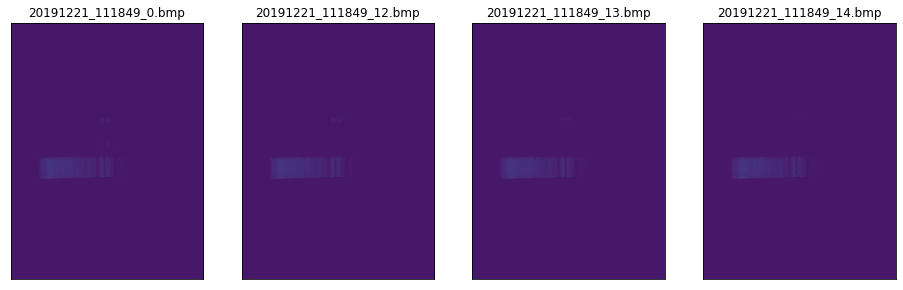

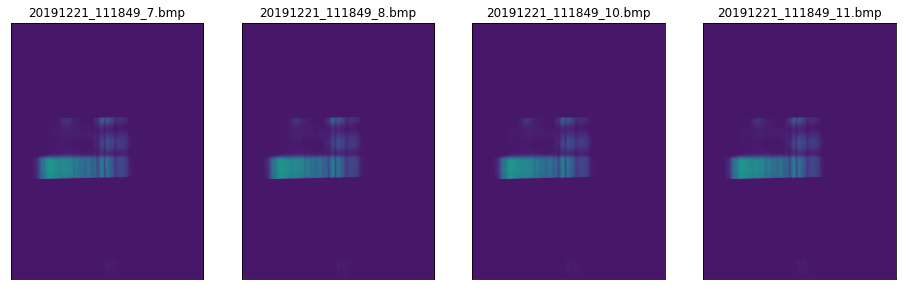

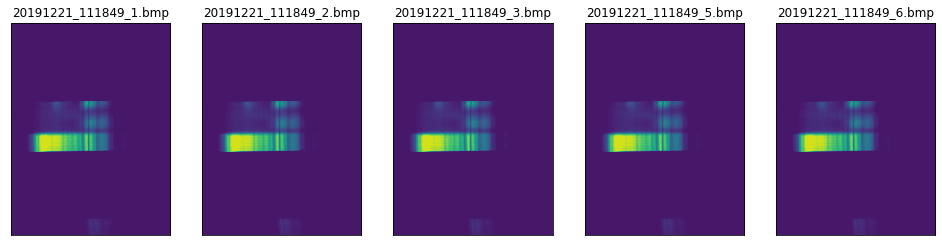

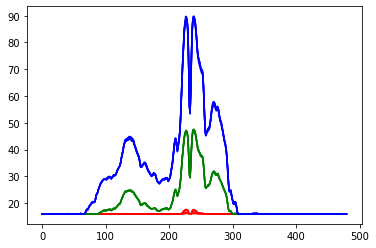

In [91]:
# sf.cleanFiles()
shotsIndex = 40
sf.shots[shotsIndex].clustering()
sf.shots[shotsIndex].showBMPs(sf.shots[shotsIndex].ExpShort)
sf.shots[shotsIndex].showBMPs(sf.shots[shotsIndex].ExpMedium)
sf.shots[shotsIndex].showBMPs(sf.shots[shotsIndex].ExpLonger)
sf.shots[shotsIndex].readGray()
sf.shots[shotsIndex].readLeaf(numSection = 5)
sf.shots[shotsIndex].showSpectrum(showLeaf = True, showGray = False)


# sf.shots[shotsIndex].calcWhite(5.96)
# sf.shots[shotsIndex].showGray()

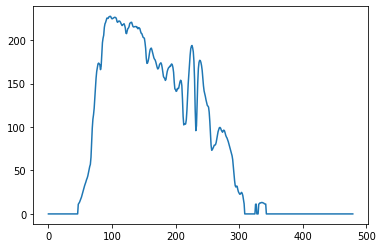

In [92]:
plt.plot(sf.shots[shotsIndex].spectrum_grayAve)

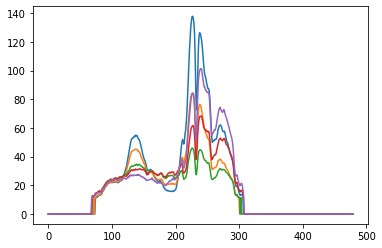

In [93]:
for i in range(5):
    plt.plot(sf.shots[shotsIndex].spectrum_leafAve[i,:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


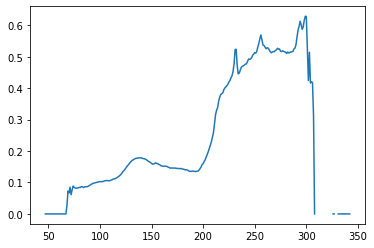

In [95]:
plt.plot(np.mean(sf.shots[shotsIndex].spectrum_leafAve, axis = 0)/sf.shots[shotsIndex].spectrum_grayAve)